**<h1>Fine-Tune Bert Masked-Language Model on Harry Potter 1 - Sorcerer's Stone as a dataset<h1>**

Masked Language Modeling (MLM) is a technique used to train models like BERT to anticipate missing words within sentences. It begins by segmenting sentences into segments and randomly obscuring certain words. Subsequently, the model develops the ability to infer the obscured words through contextual clues.

Throughout the training process, the model refines its predictions to align with the actual words in the sentence. This iterative adjustment aids the model in comprehending context and language nuances more effectively.
<br>

<img src = "https://miro.medium.com/v2/resize:fit:1400/1*phTLnQ8itb3ZX5_h9BWjWw.png" height = 300 width = 500>

In [ ]:
# Mount data from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set GPU on Enviroment
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

### **Import Libraries**

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForMaskedLM
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

**Load the model and tokenizer**

In [ ]:
# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


**Load the dataset** <br>
Here we use [Harry Potter 1 - Sorcerer's Stone Book](https://http://classics.mit.edu/Antoninus/meditations.html) as a Dataset.

In [ ]:
# Import the dataset
with open('/content/drive/MyDrive/Bert_Model/harry2.txt', 'r') as fp:
    text = fp.read().split('\n')

**Data Preprocessing** <br>
As we randomly choosing the mask from the text, that's why we can use any textual data. Here we add 15% masks in the text.

In [ ]:
# Tokenize the text
inputs = tokenizer(text, return_tensors='tf', max_length=256, truncation=True, padding='max_length')

# Mask some tokens
input_ids = inputs['input_ids']
mask_indices = (tf.random.uniform(input_ids.shape) < 0.15) & \
               (input_ids != 101) & \
               (input_ids != 102) & \
               (input_ids != 0)
mask_indices = tf.cast(mask_indices, tf.bool)
masked_input_ids = tf.where(mask_indices, 103 * tf.ones_like(input_ids), input_ids)

# Prepare dataset
dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': masked_input_ids,
                                               'attention_mask': inputs['attention_mask']},
                                              {'labels': input_ids}))

In [ ]:
# Define training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
epochs = 5
batch_size = 2

**Start Training**

In [ ]:
# Training loop
epoch_loss_save=[]
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss = 0.0
    progress_bar = tqdm(enumerate(dataset.batch(batch_size)), total=len(dataset) // batch_size)
    for i, (inputs, labels) in progress_bar:
        with tf.GradientTape() as tape:
            outputs = model(inputs, labels=labels['labels'])  # Pass labels to the model
            loss = outputs.loss
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        epoch_loss += loss.numpy()
        progress_bar.set_description(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.numpy().item():.4f}')
    epoch_loss /= (i + 1)  # Calculate average epoch loss
    print(f'Epoch {epoch + 1} Loss: {float(epoch_loss):.4f}')
    # Append the losses
    epoch_loss_save.append(epoch_loss)

Epoch 1/5


Epoch 1, Batch 1, Loss: 14.6726:   0%|          | 1/1862 [00:15<8:02:34, 15.56s/it]


KeyboardInterrupt: 

**Training Losses**

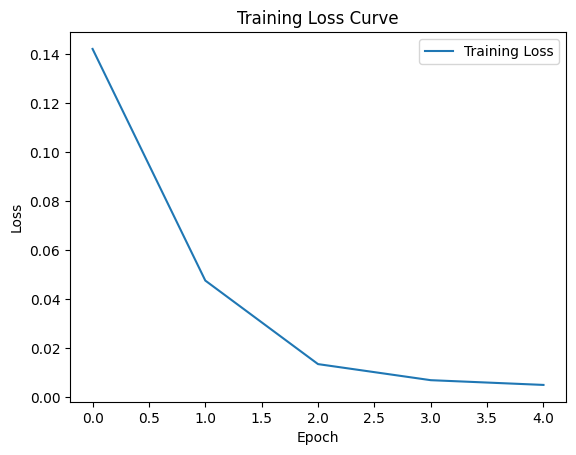

In [ ]:
# Plot the loss curve
plt.plot(epoch_loss_save, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

**Save the model**

In [ ]:
# Save the model
model.save_pretrained('/content/drive/MyDrive/Bert_Model/Tensorflow_5Epochs')

**Test the model** <br>
 Here we pass the *text* with a masked token is tokenized and passed through the model for inference.

 The top-5 predictions for the masked token are then decoded and printed along with their probabilities.

In [ ]:
# Example input text with a masked token
text = "kind of a life that is, so that, so far as depended on the [MASK]"

# Tokenize the input text
inputs = tokenizer(text, return_tensors='tf')

# Perform inference
outputs = model(inputs)

# Get the logits for the masked token
mask_token_index = tf.where(inputs['input_ids'][0] == tokenizer.mask_token_id)[0].numpy()
masked_token_logits = outputs.logits[0, mask_token_index[0]].numpy().squeeze()

# Get the top k predictions and their probabilities
top_k_indices = masked_token_logits.argsort()[-5:][::-1]
top_k_probs = tf.nn.softmax(masked_token_logits[top_k_indices])

# Decode the predicted tokens
predicted_tokens = tokenizer.decode(top_k_indices)

# Print the top k predictions and their probabilities
for token, prob in zip(predicted_tokens, top_k_probs):
    print(f"{token}: {prob}")

.: 0.96748948097229
 : 0.030732767656445503
;: 0.0009675572509877384
?: 0.0006188761326484382
 : 0.00019130020518787205


**Load the save model**

In [ ]:
# Load the saved model
loaded_model = TFBertForMaskedLM.from_pretrained('/content/drive/MyDrive/Bert_Model/Tensorflow_5Epochs')

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at /content/drive/MyDrive/Bert_Model/Tensorflow_5Epochs.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.
